#RNN GPT-2 Output Classifier

In [8]:
# Download stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import random
import re
from collections import Counter
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML
from google_drive_downloader import GoogleDriveDownloader as gdd

# Make plots look good
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')

tqdm.pandas()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#Load Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving generated_reviews (train).txt to generated_reviews (train).txt
Saving processed_fine_tuned_reviews.txt to processed_fine_tuned_reviews.txt
Saving processed_gpt2_medium_reviews.txt to processed_gpt2_medium_reviews.txt
Saving processed_human_reviews.txt to processed_human_reviews.txt
Saving processed_reviews_talk_to_transformer.txt to processed_reviews_talk_to_transformer.txt


In [0]:
def load_dataset():
  df_t2t = pd.read_csv('processed_reviews_talk_to_transformer.txt', sep="\n", header=None, names=['review'])
  df_gpt2Medium = pd.read_csv('processed_gpt2_medium_reviews.txt', sep="\n", header=None, names=['review'])
  df_fineTuned = pd.read_csv('processed_fine_tuned_reviews.txt', sep="\n", header=None, names=['review'])
  df_human = pd.read_csv('processed_human_reviews.txt', sep="\n", header=None, names=['review'])
  df_generated_reviews = pd.read_csv('generated_reviews (train).txt', sep="\n", header=None, names=['review'])
  df_t2t['label'] = 1
  df_gpt2Medium['label'] = 1
  df_fineTuned['label'] = 1
  df_generated_reviews['label'] = 1
  df_human['label'] = 0
  return df_t2t, df_gpt2Medium, df_fineTuned, df_human, df_generated_reviews

def combine_datasets():
  frames = [df_t2t, df_gpt2Medium, df_fineTuned, df_human]
  result = pd.concat(frames)
  return result

In [0]:
(df_t2t, df_gpt2Medium, df_fineTuned, df_human, df_generated_reviews) = load_dataset()
dfAmazonReviews = combine_datasets()

#Preprocess Text

In [0]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens
            else '<UNK>' for token in tokens][-max_len:]


def tokenize(text, stop_words):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = wordpunct_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    return tokens


class AmazonGPT2Dataset(Dataset):
    def __init__(self, dataset):
        df = dataset

        # Clean and tokenize
        stop_words = set(stopwords.words('english')) 
        df['tokens'] = df.review.progress_apply(
            partial(tokenize, stop_words=stop_words),
        )
        
        # Replace rare words with <UNK>
        all_tokens = [sublst for lst in df.tokens.tolist() for sublst in lst]
        common_tokens = set(list(zip(
            *Counter(all_tokens).most_common(max_vocab)))[0])
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )

        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]
        
        vocab = sorted({
            sublst for lst in df.tokens.tolist() for sublst in lst
        })
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        
        # Add a padding idx
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        df['indexed_tokens'] = df.tokens.apply(
            lambda tokens: [self.token2idx[token] for token in tokens],
        )
        self.text = df.review.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.targets = df.label.tolist()

    def __getitem__(self, i):
        return self.sequences[i], self.targets[i],  self.text[i]
    
    def __len__(self):
        return len(self.sequences)

In [9]:
# How many of the most common vocab words to keep
# Uncommon words get replaced with unknown token <UNK>
max_vocab = 1000

# How many tokens long each sequence will be cut to
# Shorter sequences will get the padding token <PAD>
max_len = 800

dataset = AmazonGPT2Dataset(dfAmazonReviews)

100%|██████████| 12643/12643 [00:00<00:00, 494457.47it/s]


#Split into training, validation, & test sets

In [0]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [11]:
valid_ratio = 0.16
test_ratio = 0.08

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=valid_ratio, test_ratio=test_ratio)
len(train_dataset), len(valid_dataset), len(test_dataset)

(9610, 2022, 1011)

In [0]:
def collate(batch):
    inputs = [item[0] for item in batch]
    target = torch.LongTensor([item[1] for item in batch])
    text = [item[2] for item in batch]
    return inputs, target, text

# Powers of two are preferred for optimal usage on the GPU
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate)

# RNN Model Architecture

In [0]:
def pad_sequences(sequences, padding_val=0, pad_left=False):
    """Pad a list of sequences to the same length with a padding_val."""
    sequence_length = max(len(sequence) for sequence in sequences)
    if not pad_left:
        return [
            sequence + (sequence_length - len(sequence)) * [padding_val]
            for sequence in sequences
        ]
    return [
        (sequence_length - len(sequence)) * [padding_val] + sequence
        for sequence in sequences
    ]


class RNNClassifier(nn.Module):
    def __init__(self, output_size, hidden_size, vocab_size, padding_idx,
                 device, dropout_probability=0.3, bidirectional=False, n_layers=1,
                 embedding_dimension=50, batch_size=32):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout_probability = dropout_probability
        self.device = device
        self.padding_idx = padding_idx
        
        # We need to multiply some layers by two if the model is bidirectional
        self.input_size_factor = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size, embedding_dimension)
        
        self.rnn = nn.LSTM(
            embedding_dimension,
            self.hidden_size,
            self.n_layers,
            bidirectional=bidirectional,
        )

        self.fc1 = nn.Linear(
            self.hidden_size * self.input_size_factor,
            16,
        )
        self.fc2 = nn.Linear(
            16,
            self.output_size,
        )


    def init_hidden(self):
        """Set initial hidden states."""
        h0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden_size,
        )
        c0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden_size,
        )
        
        h0 = h0.to(self.device)
        c0 = c0.to(self.device)

        return h0, c0
    
    def apply_rnn(self, embedding_out, lengths):
        packed = pack_padded_sequence(
            embedding_out,
            lengths,
            batch_first=True,
        )
        activations, _ = self.rnn(packed, self.init_hidden())
        activations, _ = pad_packed_sequence(activations, batch_first=True)
        
        indices = (lengths - 1).view(-1, 1).expand(
            activations.size(0), activations.size(2),
        ).unsqueeze(1)
        indices = indices.to(self.device)
        
        activations = activations.gather(1, indices).squeeze(1)
        return activations

    def forward(self, inputs, return_activations=False):
        batch_size = len(inputs)
    
        # This makes the model not break for the last batch that might be less
        # than batch_size in size
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        lengths = torch.LongTensor([len(x) for x in inputs])
        lengths, permutation_indices = lengths.sort(0, descending=True)

        # Pad sequences so that they are all the same length
        padded_inputs = pad_sequences(inputs, padding_val=self.padding_idx)
        inputs = torch.LongTensor(padded_inputs)

        # Sort inputs
        inputs = inputs[permutation_indices].to(self.device)
        
        # Get embeddings
        embedding_out = self.embedding(inputs)
        
        activations = self.apply_rnn(embedding_out, lengths)

        x = F.dropout(torch.relu(self.fc1(activations)), 0.05)
        x = self.fc2(x)
        out = torch.sigmoid(x)

        # Put the output back in correct order
        permutation_index_pairs = list(zip(
            permutation_indices.tolist(),
            list(range(len(permutation_indices))),
        ))
        reordered_indices = [
            pair[1] for pair
            in sorted(permutation_index_pairs, key=lambda pair: pair[0])
        ]

        if return_activations:
            return out[reordered_indices], x[reordered_indices]

        return out[reordered_indices]

# Train Model

In [0]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    progress_bar = tqdm_notebook(train_loader, desc='Training', leave=False)
    for inputs, target, text in progress_bar:
        target = target.to(device)

        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        output = model(inputs)

        # Calculate how wrong the model is
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        progress_bar = tqdm_notebook(valid_loader, desc='Validating', leave=False)
        for inputs, target, text in progress_bar:
            target = target.to(device)

            # Forwards pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [126]:
dropout_probability = 0.2
n_rnn_layers = 1
embedding_dimension = 256  
hidden_size = 128  
is_bidirectional = True 
max_epochs = 15
learning_rate = 0.1 

model = RNNClassifier(
    output_size=2,  # two classes: positive vs. negative
    hidden_size=hidden_size,
    embedding_dimension=embedding_dimension,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<PAD>'],
    dropout_probability=dropout_probability,
    bidirectional=is_bidirectional,
    n_layers=n_rnn_layers,
    device=device,
    batch_size=batch_size,
)
model = model.to(device)
model

RNNClassifier(
  (embedding): Embedding(1002, 256)
  (rnn): LSTM(256, 128, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [128]:
n_epochs = 0
train_losses, valid_losses = [], []
for _ in range(max_epochs):
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}'
        f'\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss
                                     for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


epoch #  1	train_loss: 5.39e-03	valid_loss: 5.23e-03



epoch #  2	train_loss: 5.19e-03	valid_loss: 5.43e-03



epoch #  3	train_loss: 5.15e-03	valid_loss: 5.37e-03



epoch #  4	train_loss: 5.21e-03	valid_loss: 5.39e-03



epoch #  5	train_loss: 5.17e-03	valid_loss: 5.54e-03

Stopping early


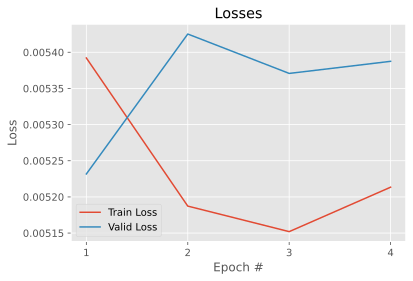

In [129]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

#Make Model Predictions

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def stats(name, y_true, y_pred):
  acc = np.mean(y_pred == y_true)
  acc = acc[0]
  # Extract TP, TN, FP, FN
  TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)

  # Specificity or true negative rate
  TNR = TN/(TN+FP)

  # Precision
  precision = TP/(TP+FP)

  # F1-Score
  f1 = (2*precision*TPR)/(precision+TPR)

  # Display results
  print(name + ' Accuracy: ' + str(acc))
  print(name + ' True Positive Rate: ' + str(TPR))
  print(name + ' True Negative Rate: ' + str(TNR))
  print(name + ' F1-score: ' + str(f1))
  print('')

  # Display Plot
  # Names of predicted classes
  class_names = ["human", "AI"]

  # Generate the confusion matrix
  cnf_matrix = confusion_matrix(y_true, y_pred)

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title= 'RNN Confusion matrix')

  plt.show()

  # Plot ROC Curve
  try:
    y_probas = model.predict_proba(x_test)
    skplt.metrics.plot_roc_curve(y_test, y_probas)
    plt.show()
  except:
    print()
    print("ROC can't be generated for " + name)

  print('-----------------------------------------------------')
  print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



              precision    recall  f1-score   support

           0       0.87      0.62      0.72       852
           1       0.20      0.52      0.29       159

    accuracy                           0.60      1011
   macro avg       0.54      0.57      0.51      1011
weighted avg       0.77      0.60      0.66      1011

RNN Accuracy: 0.6033630069238378
RNN True Positive Rate: 0.5220125786163522
RNN True Negative Rate: 0.6185446009389671
RNN F1-score: 0.2927689594356261

Confusion matrix, without normalization
[[527 325]
 [ 76  83]]


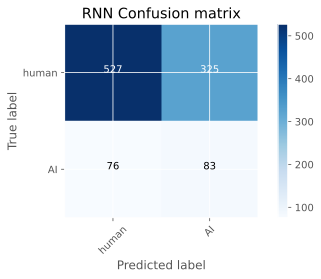


ROC can't be generated for RNN
-----------------------------------------------------



In [130]:
model.eval()
test_accuracy = n_examples = 0
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, target, text in tqdm_notebook(test_loader, leave=False):
        target = target.to(device)

        _, logits = model(inputs, return_activations=True)

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)

print()
print(classification_report(y_true, y_pred))
df_true = pd.DataFrame(y_true)
df_pred = pd.DataFrame(y_pred)
stats('RNN', df_true, df_pred)

#Sample Predictions

In [0]:
# inputs = ["Heloo my skjls sldf  lksj"]

# model.predict
# (list(df_generated_reviews['comment_text'].values))
        
# print(classification_report(y_true, y_pred))